In [ ]:
!pip install pymfe
!pip install scikit-learn
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Table representation configuration

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

Database connection

In [ ]:
import sqlite3
import pandas as pd
from sqlite3 import Error

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

Clean databases

In [ ]:
cur = conn.cursor()
cur.execute("DROP TABLE datasets")
cur.execute("DROP TABLE algorithms")
cur.execute("DROP TABLE meta_features")
cur.execute("DROP TABLE meta_features_pca")
conn.commit()

Create tables

In [ ]:

def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

database = "/content/drive/Shareddrives/AutoML/database.db"
conn = create_connection(database)

create_datasets_table = """
CREATE TABLE IF NOT EXISTS datasets (
    dataset_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_name TEXT NOT NULL UNIQUE
);
"""

create_algorithms_table = """
CREATE TABLE IF NOT EXISTS algorithms (
    algorithm_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_id INTEGER NOT NULL,
    model_name TEXT NOT NULL,
    accuracy REAL,
    precision REAL,
    recall REAL,
    f1_score REAL,
    FOREIGN KEY (dataset_id) REFERENCES datasets(dataset_id)
);
"""

create_meta_features_table = """
CREATE TABLE IF NOT EXISTS meta_features (
    meta_feature_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_id INTEGER NOT NULL,
    value TEXT,
    FOREIGN KEY (dataset_id) REFERENCES datasets(dataset_id)
);
"""

create_meta_features_pca_table = """
CREATE TABLE IF NOT EXISTS meta_features_pca (
    meta_feature_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_id INTEGER NOT NULL,
    value TEXT,
    FOREIGN KEY (dataset_id) REFERENCES datasets(dataset_id)
);
"""

create_algorithms_pca_table = """
CREATE TABLE IF NOT EXISTS algorithms_pca (
    algorithm_id INTEGER PRIMARY KEY AUTOINCREMENT,
    dataset_id INTEGER NOT NULL,
    model_name TEXT NOT NULL,
    accuracy REAL,
    precision REAL,
    recall REAL,
    f1_score REAL,
    FOREIGN KEY (dataset_id) REFERENCES datasets(dataset_id)
);
"""

create_table(conn, create_datasets_table)
create_table(conn, create_algorithms_table)
create_table(conn, create_meta_features_table)
create_table(conn, create_meta_features_pca_table)
create_table(conn, create_algorithms_pca_table)

Queries

In [ ]:
import json

# INSERT
def insert_dataset(conn, dataset_name):
    insert_sql = '''
    INSERT OR REPLACE INTO datasets (dataset_id, dataset_name)
    VALUES ((SELECT dataset_id FROM datasets WHERE dataset_name = ?), ?)
    '''
    cur = conn.cursor()
    cur.execute(insert_sql, (dataset_name, dataset_name))
    conn.commit()
    return cur.lastrowid


def insert_algorithm(conn, dataset_id, model_name, acc, prec, recall, f1, use_pca = False):
    table_name = "algorithms"
    if use_pca:
      table_name = "algorithms_pca"
    check_sql = 'SELECT algorithm_id FROM ' + table_name + ' WHERE dataset_id = ? AND model_name = ?'
    update_sql = 'UPDATE ' + table_name + ' SET accuracy = ?, precision = ?, recall = ?, f1_score = ? WHERE dataset_id = ? AND model_name = ?'
    insert_sql = 'INSERT INTO ' + table_name + ' (dataset_id, model_name, accuracy, precision, recall, f1_score) VALUES (?, ?, ?, ?, ?, ?)'

    cur = conn.cursor()

    cur.execute(check_sql, (dataset_id, model_name))
    result = cur.fetchone()

    if result:
        cur.execute(update_sql, (acc, prec, recall, f1, dataset_id, model_name))
    else:
        cur.execute(insert_sql, (dataset_id, model_name, acc, prec, recall, f1))

    conn.commit()

def insert_metafeatures(conn, dataset_id, meta_features, use_pca = False):
    meta_features = [int(x) if isinstance(x, np.int64) else x for x in meta_features]

    meta_features_values_string = json.dumps(meta_features)

    table_name = "meta_features"
    if use_pca:
      table_name = "meta_features_pca"
    check_sql = 'SELECT meta_feature_id FROM ' + table_name + ' WHERE dataset_id = ?'
    update_sql = 'UPDATE ' + table_name + ' SET value = ? WHERE dataset_id = ?'
    insert_sql = 'INSERT INTO ' + table_name + '(dataset_id, value) VALUES (?, ?)'

    cur = conn.cursor()

    cur.execute(check_sql, (dataset_id,))
    result = cur.fetchone()

    if result:
        cur.execute(update_sql, (meta_features_values_string, dataset_id))
    else:
        cur.execute(insert_sql, (dataset_id, meta_features_values_string))

    conn.commit()

# SELECT
def get_stored_meta_features(conn, use_pca = False):
    table_name = "meta_features"
    if use_pca:
      table_name = "meta_features_pca"
    query = "SELECT dataset_id, value FROM " + table_name
    df = pd.read_sql_query(query, conn)
    df['value'] = df['value'].apply(json.loads)

    stored_meta_features = {}
    for dataset_id, group in df.groupby('dataset_id'):
        stored_meta_features[dataset_id] = [item for sublist in group['value'] for item in sublist]

    return stored_meta_features

def get_algorithms_for_dataset(conn, dataset_id):
    query = "SELECT * FROM algorithms WHERE dataset_id = ?"
    df_algorithms = pd.read_sql_query(query, conn, params=(dataset_id,))
    algorithms_dict = {}
    for index, row in df_algorithms.iterrows():
        algorithms_dict[row['model_name']] = {
            'acc': row['accuracy'],
            'prec': row['precision'],
            'recall': row['recall'],
            'f1': row['f1_score']
        }
    return algorithms_dict

Show datasets database

In [ ]:
query_results = "SELECT * FROM datasets"
df_results = pd.read_sql_query(query_results, conn)
print("Results Table:")
display(df_results)

Results Table:


,dataset_id,dataset_name
0,1,titanic
1,2,titanic_pca
2,3,heart
3,4,heart_pca
4,5,fake_bills
5,6,fake_bills_pca
6,7,car_web_scraped_dataset
7,8,car_web_scraped_dataset_pca


Show algorithms database

In [ ]:
query_results = "SELECT * FROM algorithms"
df_results = pd.read_sql_query(query_results, conn)
print("Results Table:")
display(df_results)

Results Table:


,algorithm_id,dataset_id,model_name,accuracy,precision,recall,f1_score
0,1,1,KNeighborsClassifier(K=3),0.804469,0.800395,0.793436,0.796227
1,2,2,KNeighborsClassifier(K=3),0.737430,0.729644,0.724324,0.726362
2,3,1,KNeighborsClassifier(K=4),0.793296,0.801625,0.769949,0.777281
3,4,2,KNeighborsClassifier(K=4),0.759777,0.773055,0.729408,0.735725
4,5,1,KNeighborsClassifier(K=5),0.793296,0.791430,0.777928,0.782432
5,6,2,KNeighborsClassifier(K=5),0.776536,0.778221,0.755663,0.761461
6,7,1,KNeighborsClassifier(K=6),0.787709,0.790756,0.767181,0.773388
7,8,2,KNeighborsClassifier(K=6),0.770950,0.782645,0.742921,0.749838
8,9,1,KNeighborsClassifier(K=7),0.765363,0.761957,0.748134,0.752372
9,10,2,KNeighborsClassifier(K=7),0.782123,0.779352,0.766409,0.770671


Show algorithms pca database

In [ ]:
query_results = "SELECT * FROM algorithms_pca"
df_results = pd.read_sql_query(query_results, conn)
print("Results Table:")
display(df_results)

Results Table:


,algorithm_id,dataset_id,model_name,accuracy,precision,recall,f1_score


Show meta features database

In [ ]:
query_meta_features = "SELECT * FROM meta_features"
df_meta_features = pd.read_sql_query(query_meta_features, conn)
print("\nMeta-Features Table:")
display(df_meta_features)


Meta-Features Table:


,meta_feature_id,dataset_id,value
0,1,1,"[0.05193579883453314, 0.08976199766960609, 2.0..."
1,2,2,"[0.12137349436893535, 0.1656777311835868, 3.16..."
2,3,3,"[0.03667789505002395, 0.047598995991964724, 1...."
3,4,4,"[0.1719844333594078, 0.1964769863496327, 2.584..."
4,5,5,"[0.02103368226560804, 0.015341896497302847, 3...."
5,6,6,"[0.011108647886980854, 0.004343640395451524, 3..."
6,7,7,"[0.02479471510951754, 0.03599712898434929, 3.1..."
7,8,8,"[0.022585311594321436, 0.008561862247033415, 3..."


Show pca meta features database

In [ ]:
query_meta_features_pca = "SELECT * FROM meta_features_pca"
df_meta_features = pd.read_sql_query(query_meta_features_pca, conn)
print("\nPCA Meta-Features Table:")
display(df_meta_features)


PCA Meta-Features Table:


,meta_feature_id,dataset_id,value


Extract meta features

In [ ]:
from pymfe.mfe import MFE
import math

groups = [
    "general",
    "statistical",
    "info-theory"
]

features = [
    "nr_inst",
    "nr_class",
    "nr_attr"
]

def extract_meta_features(X, y):
  # mfe = MFE(groups=groups, features=features)
  # mfe = MFE(groups=groups, random_state=42)
  mfe = MFE(random_state=42)
  mfe.fit(X, y)

  names, values = mfe.extract()

  string_names = [str(element) for element in names]
  cleaned_values = [0.0 if math.isnan(value) else np.finfo(float).max if np.isinf(value) else value for value in values]

  return string_names, cleaned_values

Prepare and load dataset functions

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

def preprocess_column(column):
    if column.dtype == object or column.dtype.name == 'category':
        return LabelEncoder().fit_transform(column.astype(str))
    else:
        return column.fillna(column.mean())

def preprocess_dataset(df, target_column, title, use_pca = False):
    #display(df)
    df = df.apply(preprocess_column, axis=0)

    X = df.drop(target_column, axis=1)
    #display(X)
    y = df[target_column].values
    #display(y)

    if not use_pca:
      visualization(X, y, "Unscaled dataset " + title)

    scaler = MinMaxScaler()

    X_scaled = scaler.fit_transform(X)
    if not use_pca:
      visualization(X_scaled, y, "Scaled dataset " + title)

    return X_scaled, y


Train function

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def train_eval_model(X_train, X_test, y_train, y_test, model):
    pipeline = make_pipeline(StandardScaler(), model)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    return acc, prec, recall, f1

Calculate algorithm_metrics

In [ ]:
def calculate_algorithm_metrics(X, y, model):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return train_eval_model(X_train, X_test, y_train, y_test, model)

Read dataset files

In [ ]:
def read_dataset(dataset_path):
  df = pd.read_csv(dataset_path)
  #df.columns = df.columns.astype(str)
  return df

Models and datasets

In [ ]:
models = {
          "KNeighborsClassifier(K=3)": KNeighborsClassifier(n_neighbors=3),
          "KNeighborsClassifier(K=4)": KNeighborsClassifier(n_neighbors=4),
          "KNeighborsClassifier(K=5)": KNeighborsClassifier(n_neighbors=5),
          "KNeighborsClassifier(K=6)": KNeighborsClassifier(n_neighbors=6),
          "KNeighborsClassifier(K=7)": KNeighborsClassifier(n_neighbors=7),
          "LogisticRegression": LogisticRegression(max_iter=1000)
        }

datasets_info = {
    'Titanic': {
        'path': '/content/drive/Shareddrives/AutoML/titanic.csv',
        'target_column': 'Survived'
    },
    'Heart': {
        'path': '/content/drive/Shareddrives/AutoML/heart.csv',
        'target_column': 'output'
    },
    'FakeBills': {
        'path': '/content/drive/Shareddrives/AutoML/fake_bills.csv',
        'target_column': 'is_genuine'
    },
    'Cars': {
        'path': '/content/drive/Shareddrives/AutoML/car_web_scraped_dataset.csv',
        'target_column': 'price'
    }
  }


Configuring PCA

In [ ]:
from sklearn.decomposition import PCA

n_components = 3
pca = PCA(n_components = n_components)

Visualization

In [ ]:
import matplotlib.pyplot as plt

def visualization(X, y, title):

  pca = PCA(n_components = 2)
  pca_X = pca.fit_transform(X)
  #print(f"dataset x: {X}")

  # Vizualizacija rezultata
  plt.scatter(pca_X[:, 0], pca_X[:, 1], c=y, cmap='viridis')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.title(title)
  plt.show()


In [ ]:
import csv
meta_features_file = '/content/drive/Shareddrives/AutoML/meta-features.csv'
def is_header_written(expected_header):
    with open(meta_features_file, 'r', newline='') as file:
        csv_reader = csv.reader(file)
        try:
            # Pročitaj prvi red iz fajla
            first_row = next(csv_reader)

            # Uporedi sa očekivanim header-om
            return first_row == expected_header
        except StopIteration:
            # Fajl je prazan (nema redova)
            return False

def insert_meta_features_in_csv_file(expected_header, new_row):
  with open(meta_features_file, 'a', newline='') as file:
    csv_writer = csv.writer(file)
    if not is_header_written(expected_header):
      csv_writer.writerow(expected_header)
    # Dodavanje novih redova
    csv_writer.writerow(new_row)

def empty_file():
  with open(meta_features_file, 'w'):
    pass

Reading meta features dataset

In [ ]:
def meta_features_dataset(target_meta_feature):
  dataset = read_dataset(meta_features_file)
  X, y = preprocess_dataset(dataset, target_meta_feature, "Meta features", True)
  return X, y

Training phase code block

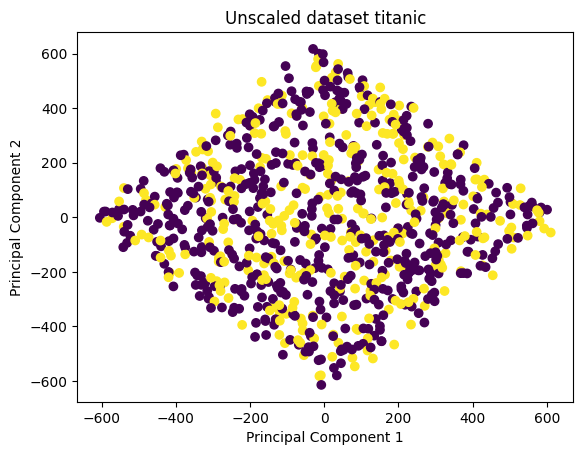

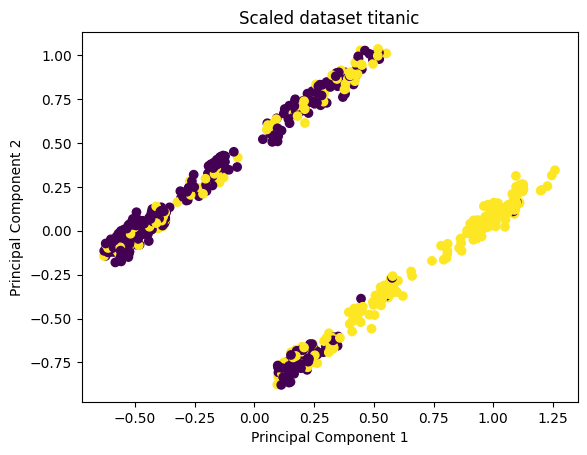

/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:731: RuntimeWarning: Can't summarize feature 'can_cor' with summary 'sd'. Will set it as 'np.nan'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymfe/statistical.py:1267: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(S_i)) for S_i in sample_cov_matrices
/usr/local/lib/python3.10/dist-packages/pymfe/statistical.py:1272: RuntimeWarning: invalid value encountered in log
  * np.log(np.linalg.det(pooled_cov_mat))
/usr/local/lib/python3.10/dist-pac

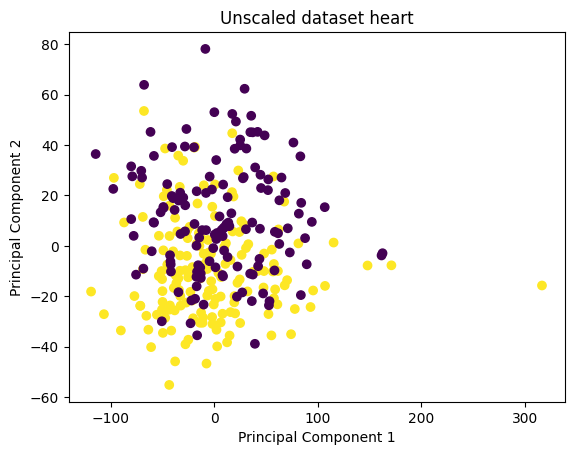

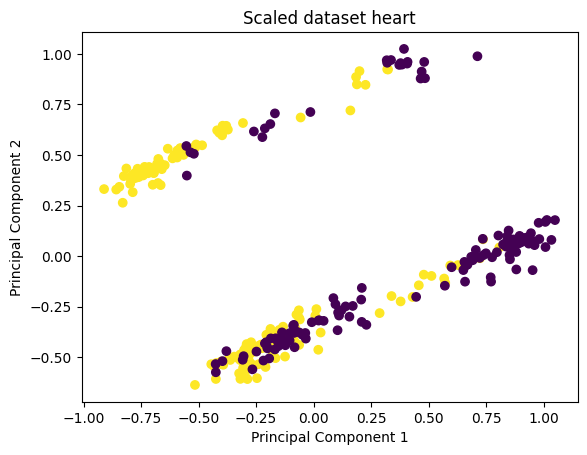

/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:731: RuntimeWarning: Can't summarize feature 'can_cor' with summary 'sd'. Will set it as 'np.nan'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:731: RuntimeWarning: Can't summarize fe

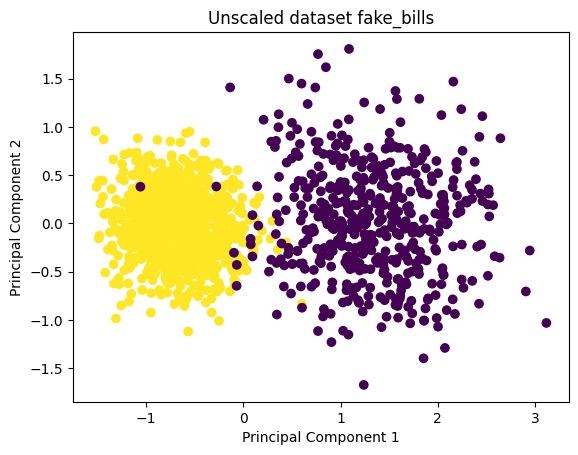

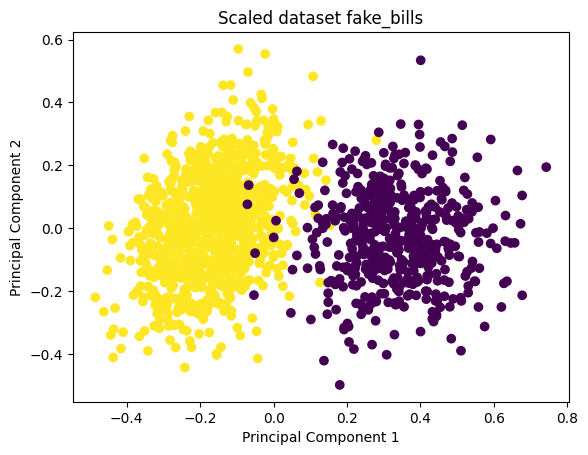

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:731: RuntimeWarning: Can't summarize feature 'can_cor' with summary 'sd'. Will set it as 'np.nan'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymfe/statistical.py:1267: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(S_i)) for S_i in sample_cov_matrices
/usr/local/lib/python3.10/dist-packages/pymfe/statistical.py:1272: RuntimeWarning: invalid value encountered in log
  * np.log(np.linalg.det(pooled_cov_mat))
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave

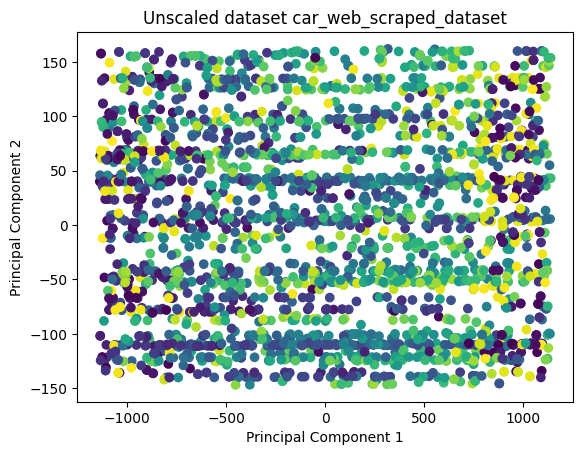

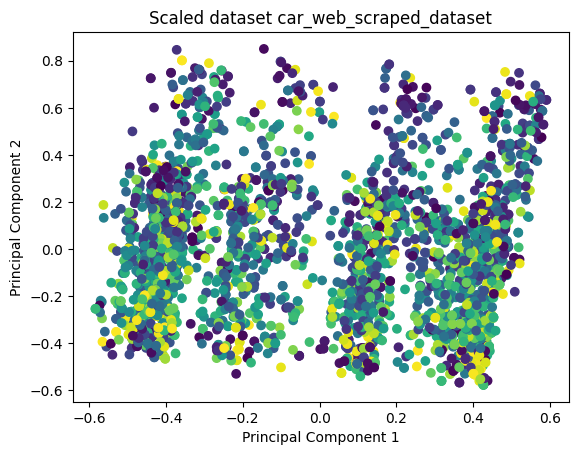

/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less th

In [ ]:
empty_file()
for dataset_name, info in datasets_info.items():
  dataset_path = info['path']
  target_column = info['target_column']

  dataset = read_dataset(dataset_path)
  dataset_name = dataset_path.split('/')[-1].replace('.csv', '')
  dataset_id = insert_dataset(conn, dataset_name)

  X, y = preprocess_dataset(dataset, target_column, dataset_name)

  meta_feature_name, meta_feature_values = extract_meta_features(X, y)
  insert_meta_features_in_csv_file(meta_feature_name, meta_feature_values)
  insert_metafeatures(conn, dataset_id, meta_feature_values)

  pca_dataset_id = insert_dataset(conn, dataset_name + "_pca")
  X_pca = pca.fit_transform(X)
  meta_feature_name_pca, meta_feature_values_pca = extract_meta_features(X_pca, y)
  insert_meta_features_in_csv_file(meta_feature_name_pca, meta_feature_values_pca)
  insert_metafeatures(conn, pca_dataset_id, meta_feature_values_pca)

  for model_name, model in models.items():
    acc, prec, recall, f1 = calculate_algorithm_metrics(X, y, model)
    insert_algorithm(conn, dataset_id, model_name, acc, prec, recall, f1)
    acc, prec, recall, f1 = calculate_algorithm_metrics(X_pca, y, model)
    insert_algorithm(conn, pca_dataset_id, model_name, acc, prec, recall, f1)


In [ ]:
  #NE POKRETATI :D
  meta_feature_pca = PCA(4)

  mf_X, mf_y = meta_features_dataset(meta_feature_name[0])
  meta_features_pca = meta_feature_pca.fit_transform(mf_X)
  print(f"METAA FEATURE {meta_features_pca}") # -> 2D array
  #ovde je greska
  #ne znamo kako da izvucemo koji je meta feature sad bas za ovaj set
  insert_metafeatures(conn, pca_dataset_id, meta_feature_values, True)

  mf_pca_X, mf_pca_y = meta_features_dataset(meta_feature_name[0])
  meta_features_pca = meta_feature_pca.fit_transform(mf_pca_X)
  insert_metafeatures(conn, pca_dataset_id, meta_feature_values, True)

METAA FEATURE [[-2.32299084 -2.17326953  2.18748569 -0.66949419]
 [-1.47508898  2.72518677  0.93216402  1.33197109]
 [-1.68783276 -2.64008922 -1.99448766  0.47429195]
 [-1.77505054  2.31619111 -1.32929092 -0.92080341]
 [ 3.86897012 -1.2575566   0.08010905  0.64605434]
 [ 3.39199298  1.02953748  0.12401983 -0.86201978]]


**After training**

Calculate euclidean distances

In [ ]:
from scipy.spatial import distance

# def calculate_euclidean_distances(new_meta_features, stored_meta_features):
#     distances = {}
#     for dataset_id, features in stored_meta_features.items():
#         common_keys = set(new_meta_features.keys()) & set(features.keys())
#         if common_keys:
#             new_features = [new_meta_features[k] for k in common_keys]
#             stored_features = [features[k] for k in common_keys]
#             dist = distance.euclidean(new_features, stored_features)
#             distances[dataset_id] = dist
#     return distances

def calculate_euclidean_distances(new_meta_features, stored_meta_features):
    distances = {}
    for dataset_id, values_list in stored_meta_features.items():
        if new_meta_features and values_list and len(new_meta_features) == len(values_list):
            dist = distance.euclidean(new_meta_features, values_list)
            distances[dataset_id] = dist
    return distances


Identify closest dataset

In [ ]:
def find_closest_dataset(conn, new_meta_feature_values, use_pca = False):
    stored_meta_features = get_stored_meta_features(conn, use_pca)
    distances = calculate_euclidean_distances(new_meta_feature_values, stored_meta_features)
    closest_dataset_id = min(distances, key=distances.get)
    return closest_dataset_id

Calculate weighted score

In [ ]:
def negative_to_zero(x):
  if (x < 0):
    return 0
  return x

def calculate_weighted_score(metrics, acc_weight=1, prec_weight=1, recall_weight=1, f1_weight=1):
    acc_weight = negative_to_zero(acc_weight);
    prec_weight = negative_to_zero(prec_weight);
    recall_weight = negative_to_zero(recall_weight);
    f1_weight = negative_to_zero(f1_weight);
    weighted_score = (acc_weight * metrics['acc']
                      + prec_weight * metrics['prec']
                      + recall_weight * metrics['recall']
                      + f1_weight * metrics['f1']) / (acc_weight + prec_weight + recall_weight + f1_weight)
    return weighted_score

Find best matching algorithm

In [ ]:
def find_best_performing_algorithm(algorithms_dict, acc_weight=1, prec_weight=1, recall_weight=1, f1_weight=1):
    best_match = None
    highest_score = float('-inf')

    for model_name, metrics in algorithms_dict.items():
        algorithm_score = calculate_weighted_score(metrics, acc_weight, prec_weight, recall_weight, f1_weight)

        if algorithm_score > highest_score:
            highest_score = algorithm_score
            best_match = model_name

    return best_match

Process new dataset

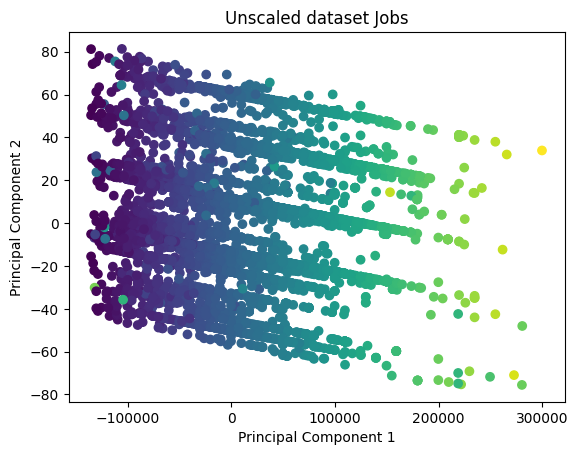

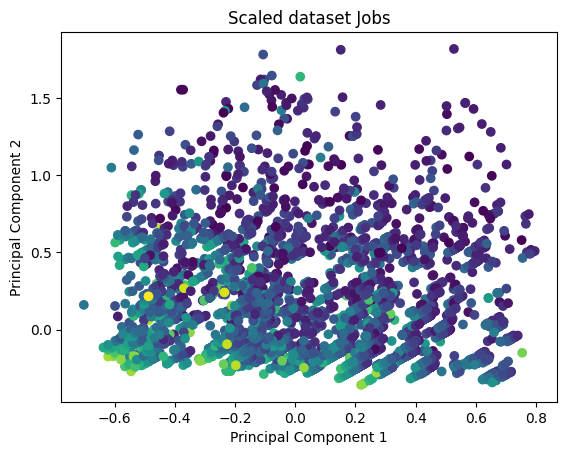

/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less th

Closest Dataset ID: 25
Best matching algorithm: LogisticRegression
acc: 0.08872260823089258, prec: 0.014147757011305823, recall: 0.027654440478062085, f1: 0.015134736596622348


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is le

PCA Dataset - Closest Dataset ID: 25
PCA Dataset - best matching algorithm: LogisticRegression
PCA Dataset - acc: 0.028861571352218066, PCA prec: 0.0007125307956669275, PCA recall: 0.005480408733657708, PCA f1: 0.0011426958556630415


In [ ]:
new_dataset_info = {
  'title': 'Jobs',
  'path': '/content/drive/Shareddrives/AutoML/jobs_in_data.csv',
  'target_column': 'salary'
}

dataset = read_dataset(new_dataset_info['path'])
X, y = preprocess_dataset(dataset, new_dataset_info['target_column'], new_dataset_info['title'])

#without PCA
new_meta_feature_names, new_meta_feature_values = extract_meta_features(X, y)
insert_meta_features_in_csv_file(new_meta_feature_names, new_meta_feature_values)
mf_X, mf_y = meta_features_dataset(new_meta_feature_names[0])

closest_dataset_id = find_closest_dataset(conn, new_meta_feature_values)
print(f"Closest Dataset ID: {closest_dataset_id}")

algorithms = get_algorithms_for_dataset(conn, closest_dataset_id)

best_matching_algorithm = find_best_performing_algorithm(algorithms)
print(f"Best matching algorithm: {best_matching_algorithm}")

acc, prec, recall, f1 = calculate_algorithm_metrics(X, y, models[best_matching_algorithm])
print(f"acc: {acc}, prec: {prec}, recall: {recall}, f1: {f1}")

#with PCA on dataset

X_pca = pca.fit_transform(X)
pca_new_meta_feature_names, pca_new_meta_feature_values = extract_meta_features(X_pca, y)
insert_meta_features_in_csv_file(pca_new_meta_feature_names, pca_new_meta_feature_values)

pca_closest_dataset_id = find_closest_dataset(conn, pca_new_meta_feature_values)
print(f"PCA Dataset - Closest Dataset ID: {pca_closest_dataset_id}")

pca_algorithms = get_algorithms_for_dataset(conn, pca_closest_dataset_id)

pca_best_matching_algorithm = find_best_performing_algorithm(pca_algorithms)
print(f"PCA Dataset - best matching algorithm: {pca_best_matching_algorithm}")

pca_acc, pca_prec, pca_recall, pca_f1 = calculate_algorithm_metrics(X_pca, y, models[pca_best_matching_algorithm])
print(f"PCA Dataset - acc: {pca_acc}, PCA prec: {pca_prec}, PCA recall: {pca_recall}, PCA f1: {pca_f1}")


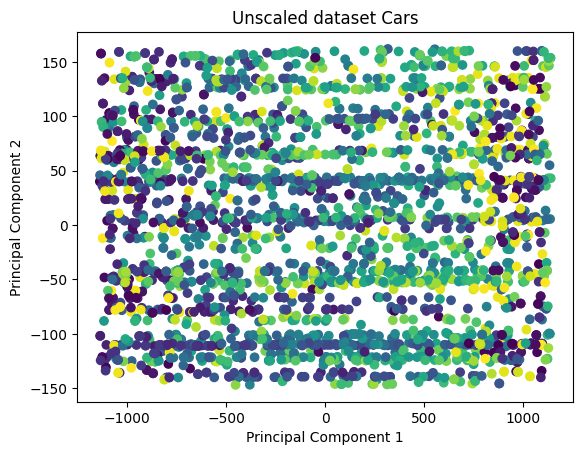

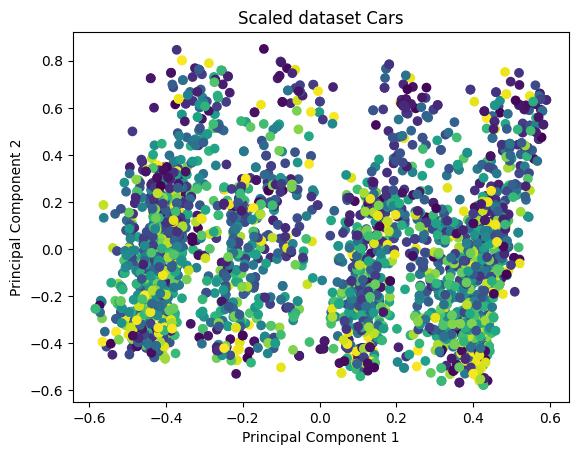

/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:1568: UserWarning: It is not possible make equal discretization
  warnings.warn("It is not possible make equal discretization")
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less th

Closest Dataset ID: 25
Best matching algorithm: LogisticRegression
acc: 0.022887323943661973, prec: 0.0015410035917022998, recall: 0.008351704879482657, f1: 0.0025069776896206124


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is le

PCA Dataset - Closest Dataset ID: 25
PCA Dataset - best matching algorithm: LogisticRegression
PCA Dataset - acc: 0.01232394366197183, PCA prec: 0.00027739956658125864, PCA recall: 0.004068423485899214, PCA f1: 0.0005185143169763516


In [ ]:
new_dataset_info = {
  'title': 'Cars',
  'path': '/content/drive/Shareddrives/AutoML/car_web_scraped_dataset.csv',
  'target_column': 'price'
}

dataset = read_dataset(new_dataset_info['path'])
X, y = preprocess_dataset(dataset, new_dataset_info['target_column'], new_dataset_info['title'])

#without PCA
new_meta_feature_names, new_meta_feature_values = extract_meta_features(X, y)
insert_meta_features_in_csv_file(new_meta_feature_names, new_meta_feature_values)
mf_X, mf_y = meta_features_dataset(new_meta_feature_names[0])

closest_dataset_id = find_closest_dataset(conn, new_meta_feature_values)
print(f"Closest Dataset ID: {closest_dataset_id}")

algorithms = get_algorithms_for_dataset(conn, closest_dataset_id)

best_matching_algorithm = find_best_performing_algorithm(algorithms)
print(f"Best matching algorithm: {best_matching_algorithm}")

acc, prec, recall, f1 = calculate_algorithm_metrics(X, y, models[best_matching_algorithm])
print(f"acc: {acc}, prec: {prec}, recall: {recall}, f1: {f1}")

#with PCA on dataset

X_pca = pca.fit_transform(X)
pca_new_meta_feature_names, pca_new_meta_feature_values = extract_meta_features(X_pca, y)
insert_meta_features_in_csv_file(pca_new_meta_feature_names, pca_new_meta_feature_values)

pca_closest_dataset_id = find_closest_dataset(conn, pca_new_meta_feature_values)
print(f"PCA Dataset - Closest Dataset ID: {pca_closest_dataset_id}")

pca_algorithms = get_algorithms_for_dataset(conn, pca_closest_dataset_id)

pca_best_matching_algorithm = find_best_performing_algorithm(pca_algorithms)
print(f"PCA Dataset - best matching algorithm: {pca_best_matching_algorithm}")

pca_acc, pca_prec, pca_recall, pca_f1 = calculate_algorithm_metrics(X_pca, y, models[pca_best_matching_algorithm])
print(f"PCA Dataset - acc: {pca_acc}, PCA prec: {pca_prec}, PCA recall: {pca_recall}, PCA f1: {pca_f1}")


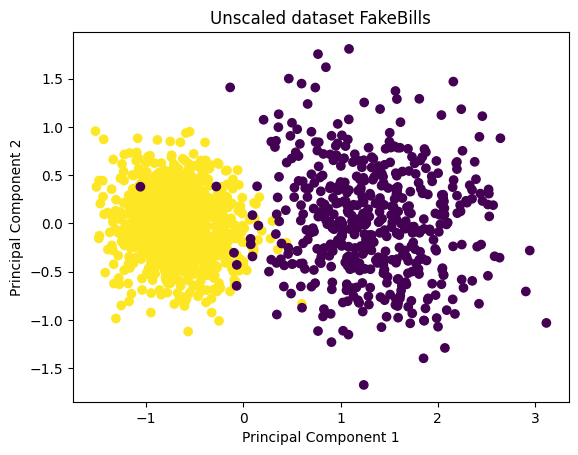

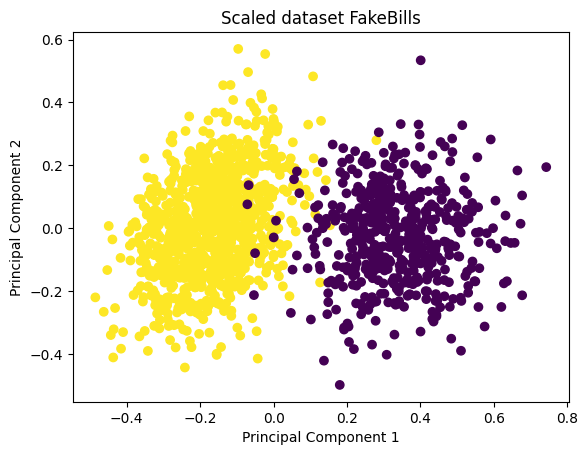

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymfe/_internal.py:731: RuntimeWarning: Can't summarize feature 'can_cor' with summary 'sd'. Will set it as 'np.nan'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymfe/statistical.py:1267: RuntimeWarning: invalid value encountered in log
  np.log(np.linalg.det(S_i)) for S_i in sample_cov_matrices
/usr/local/lib/python3.10/dist-packages/pymfe/statistical.py:1272: RuntimeWarning: invalid value encountered in log
  * np.log(np.linalg.det(pooled_cov_mat))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
#with PCA on metafeatures
new_dataset_info = {
  'title': 'FakeBills',
  'path': '/content/drive/Shareddrives/AutoML/fake_bills.csv',
  'target_column': 'is_genuine'
}

dataset = read_dataset(new_dataset_info['path'])
X, y = preprocess_dataset(dataset, new_dataset_info['target_column'], new_dataset_info['title'])
new_meta_feature_names, new_meta_feature_values = extract_meta_features(X, y)
insert_meta_features_in_csv_file(new_meta_feature_names, new_meta_feature_values)

# pca radi nad dataset-om -> ovde taj dataset treba da bude zapravo skup svih izracunatih meta-feature sa ovim novim
#dataset 1 ->. [x1, x2, .... , xn] - u bazi
#dataset 2 -> [y1,y2, .... , yn] - u bazi
#dataset 3 je nov
# izrcunati za njega meta-feature-i  -> [z1,z2, .... , zn]
# 2D array = [[x1, x2, .... , xn], [y1,y2, .... , yn], [z1,z2, .... , zn]]
mf_X, mf_y = meta_features_dataset(new_meta_feature_names[0])
meta_features_pca = pca.fit_transform(mf_X)
#poredimo sa ostalim meta feature-ima
pca_closest_dataset_id = find_closest_dataset(conn, meta_features_pca, True)
print(f"PCA Metafeatures - Closest Dataset ID: {pca_closest_dataset_id}")

pca_algorithms = get_algorithms_for_dataset(conn, pca_closest_dataset_id)

pca_best_matching_algorithm = find_best_performing_algorithm(pca_algorithms)
print(f"PCA Metafeatures - Best matching algorithm: {pca_best_matching_algorithm}")

pca_acc, pca_prec, pca_recall, pca_f1 = calculate_algorithm_metrics(X, y, models[pca_best_matching_algorithm])
print(f"PCA Metafeatures - acc: {pca_acc}, prec: {pca_prec}, recall: {pca_recall}, f1: {pca_f1}")